### Property tax calculation

Let's consider a scenario similar to the one shown below:

![here](property_tax.png)

#### Notes:

- Tax is computed on assessed property value. Value is assessed each year. We assume some constant rate of property appreciation for tax purposes in this calculation.
- Homestead exemption can be claimed after first year only as you only qualify for it if you live in the house on Jan 1 of the tax year. This is ignored in this calculation.
- Property tax rates can rise. This is also ignored in this calculation. 

In [19]:
class PropertyTaxExemption(object):
    def __init__(self, *args, **kwargs):
        raise NotImplementedError
        
    def apply_exemption(self, gross):
        raise NotImplementedError
        

class LumpsumExemption(PropertyTaxExemption):
    def __init__(self, lumpsum):
        self.lumpsum = lumpsum
        
    def apply_exemption(self, gross):
        return max(gross - self.lumpsum, 0.0)
    

class PercentExemption(PropertyTaxExemption):
    def __init__(self, rate):
        self.rate = rate
        
    def apply_exemption(self, gross):
        return (1 - self.rate) * gross

    
# Adjust these values to compute different tax scenarios
PROPERTY_TAX_LEVIES = {
    # "tax name": (rate, exemption)
    "Travis County": (0.3838/100, PercentExemption(0.2)),
    "Central Health": (0.110541/100, PercentExemption(0.2)),
    "ACC": (0.102/100, LumpsumExemption(5000)),
    "CoA": (0.4418/100, LumpsumExemption(25000)),
    "ISD": (1.515/100, LumpsumExemption(25000)),
    "Misc": (0.07299/100, LumpsumExemption(0)),
}
PROPERTY_APPRECIATION_RATE = 0.04

In [20]:
%%capture 

# Get the loan specifics from the relevant workbook
%run amortization_schedule_workbook.ipynb

# Calculate purchase price of property (assumes 20% downpayment)
PURCHASE_PRICE = PRINCIPAL / 0.8

# Property tax computation
class BasicPropertyTax(object):
    def __init__(self, initial_value=PURCHASE_PRICE, appreciation_rate=PROPERTY_APPRECIATION_RATE, taxes=PROPERTY_TAX_LEVIES):
        self.initial_home_value = initial_value
        self.appreciation_rate = appreciation_rate
        self.tax_dict = taxes
        
    def property_value_in_year(self, yearnum):
        return compound_interest(self.initial_home_value, self.appreciation_rate, yearnum) + self.initial_home_value
    
    def tax_burden_in_year(self, yearnum):
        asset_value = self.property_value_in_year(yearnum)
        tax_burden = 0
        for _, (rate, exemption) in self.tax_dict.iteritems():
            taxable_value = exemption.apply_exemption(asset_value)
            tax_burden += rate * taxable_value
        effective_tax_rate = (tax_burden / asset_value) * 100
        return (tax_burden, effective_tax_rate)

In [28]:
# Let's confirm that our computation works.
# Using the same values as the ones assumed in the table above should give tax burden of ~$7403
propertytax = BasicPropertyTax()
print("Property tax burden at purchase price is ${:.2f} with an effective rate of {:.2f}%.".format(*propertytax.tax_burden_in_year(0)))

Property tax burden at purchase price is $7403.40 with an effective rate of 2.37%.


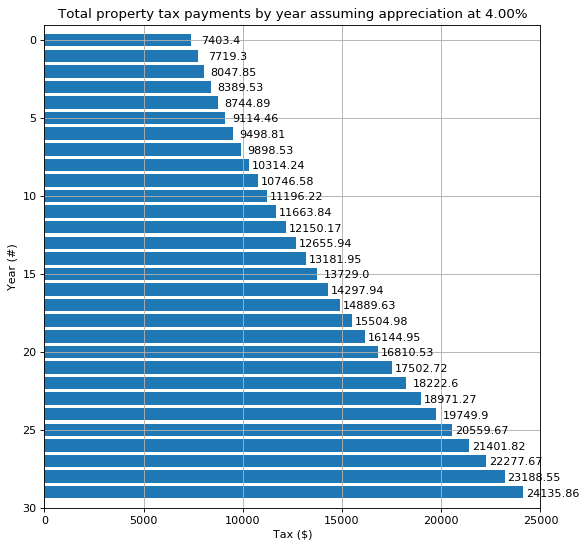

In [38]:
# Property tax burden per year
years = range(0, 30)
tax_amount = []
effective_rate = []
for year in years:
    amt, rate = propertytax.tax_burden_in_year(year)
    tax_amount.append(round(amt, 2))
    effective_rate.append(round(rate, 2))
    
# Plot annual tax payments
plt.title("Total property tax payments by year assuming appreciation at {:.2f}%".format(propertytax.appreciation_rate * 100))
k = plt.barh(years, tax_amount,)
plt.ylabel("Year (#)")
plt.ylim([30, -1])
plt.xlabel("Tax ($)")
plt.xlim([0, 25000])
plt.grid()

# Add value labels
ax = plt.gca()
bars = ax.patches
for bar, label in zip(bars, tax_amount):
    width = bar.get_width()
    ax.text(width + 1500, bar.get_y() + bar.get_height(), label, ha='center', va='bottom')

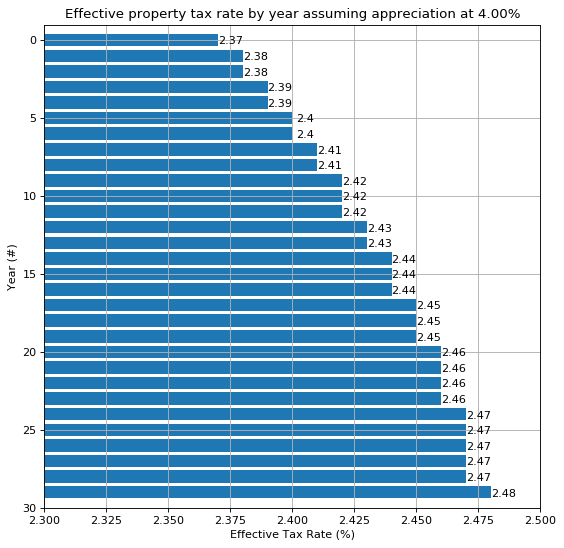

In [51]:
# Plot effective tax rate
plt.title("Effective property tax rate by year assuming appreciation at {:.2f}%".format(propertytax.appreciation_rate * 100))
k = plt.barh(years, effective_rate,)
plt.ylabel("Year (#)")
plt.ylim([30, -1])
plt.xlabel("Effective Tax Rate (%)")
plt.xlim([2.3, 2.5])
plt.grid()

# Add value labels
ax = plt.gca()
bars = ax.patches
for bar, label in zip(bars, effective_rate):
    width = bar.get_width()
    ax.text(width + 0.005, bar.get_y() + bar.get_height(), label, ha='center', va='bottom')